**NOTE:** I managed to get an LB of 0.0052 with this code, but due to some randomness still in the script, the score varies between 0.016 and 0.005. Using some form of kfold-validation reduces this variance.

**EDIT:** I would run this somewhere other than Kaggle locally for 150 epochs instead of 89 like I have it set to below; 89 is the best I could do without the script timing out.

# The Idea

I started this competition by simply feeding the pre-extracted features into a multi-layer perceptron with one hidden layer and got surprisingly good results, but I still had all this image data that I wasn't using. My immediate thought then was to simply combine a convolutional neural network on the images with the pre-extracted features MLP and train the entire model end to end. Keras's functional API gives us a really easy way to do this. Below, I'll outline the process of getting this model working along, point out some nice resources to learning about convolutional nets, and do some visualization of what the neural network is actually doing. But before we do that, let's just get all the data loading out of the way.

In [24]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# If you want to use Theano, all you need to change
# is the dim ordering whenever you are dealing with
# the image array. Instead of
# (samples, rows, cols, channels) it should be
# (samples, channels, rows, cols)

# Keras stuff
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

# A large amount of the data loading code is based on najeebkhan's kernel
# Check it out at https://www.kaggle.com/najeebkhan/leaf-classification/neural-network-through-keras
root = '..\leaf\leaf-classification'
np.random.seed(2016)
split_random_state = 7
split = .9
print(os.path.join(root, 'train.csv'))

def load_numeric_training(standardize=True):
    """
    Loads the pre-extracted features for the training data
    and returns a tuple of the image ids, the data, and the labels
    """
    # Read data from the CSV file
    data = pd.read_csv(os.path.join(root, 'train.csv'))
    ID = data.pop('id')

    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    return ID, X, y


def load_numeric_test(standardize=True):
    """
    Loads the pre-extracted features for the test data
    and returns a tuple of the image ids, the data
    """
    test = pd.read_csv(os.path.join(root, 'test.csv'))
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=96):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(ids, max_dim=96, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(ids):
        # Turn the image into an array
        x = resize_img(load_img(os.path.join(root, 'images', str(idee) + '.jpg'), color_mode="grayscale"), max_dim=max_dim)
        x = img_to_array(x)
        # Get the corners of the bounding box for the image
        # NOTE: Theano users comment the two lines below and
        length = x.shape[0]
        width = x.shape[1]
        # length = x.shape[1] # uncomment this
        # width = x.shape[2] # uncomment this
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        # NOTE: Theano users comment line below and
        X[i, h1:h2, w1:w2, 0:1] = x
        # X[i, 0:1, h1:h2, w1:w2] = x  # uncomment this
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val) = load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)
print('Training data loaded!')

<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\l'
C:\Users\yamada.n\AppData\Local\Temp\ipykernel_21832\252395638.py:21: SyntaxWarning: invalid escape sequence '\l'
  root = '..\leaf\leaf-classification'


..\leaf\leaf-classification\train.csv
Loading the training data...
Training data loaded!


# Data Augmentation

One trick we are going to use to improve the robustness of our model is image data augmentation, allowing it to perform better on the test set. 

If you take a look at [Rhyando Anggoro Adi's post](https://www.kaggle.com/c/leaf-classification/forums/t/24764/create-gif-based-on-leaf-class) on the forum containing a GIF of each training sample for each species, you'll notice that for a given species most of the leaves look very similar except that the leaf is rotated slightly or is slightly larger in scale. We'll try to emphasize this in our dataset by randomly performing a rotation or zoom transformation to each leaf image as the image is passed to the neural network. Below is the code for the data augmentation image generator along with a slight change to the source code to help us out later on.

**NOTE:** the change to the source code is not the only way to get around the problem of matching the indices of our two inputs (images and pre-extracted features). You can also manually shuffle the indices, set the shuffle parameter for the ImageDataGenerator to False, and flow the generator from the manually shuffled images.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img

# A little hacky piece of code to get access to the indices of the images
# the data augmenter is working with.
class ImageDataGenerator2(ImageDataGenerator):
    def flow(self, X, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator2(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)


class NumpyArrayIterator2(NumpyArrayIterator):
    def next(self):
        # for python 2.x.
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            # We changed index_array to self.index_array
            self.index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
        for i, j in enumerate(self.index_array):
            x = self.X[j]
            x = self.image_data_generator.random_transform(x.astype('float32'))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[self.index_array]
        return batch_x, batch_y

print('Creating Data Augmenter...')
imgen = ImageDataGenerator2(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
imgen_train = imgen.flow(X_img_tr, y_tr_cat, seed=np.random.randint(1, 10000)) #save_to_dir= '../leaf/changeimagecheck' ,save_prefix='generated', save_format='jpg',
print('Finished making data augmenter...')

Creating Data Augmenter...
Finished making data augmenter...


# Combining the Image CNN with the Pre-Extracted Features MLP

Now that we've gotten all the data preparation work out of the way, we can actually construct our model.

## Wait!! I don't know what a convolutional neural network is!

No worries! I've linked below a few great places to get an overview of convnets. You can find more by just googling "convolutional neural network explained".

* http://cs231n.github.io/convolutional-networks/
* https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/
* http://neuralnetworksanddeeplearning.com/chap6.html

## Keras Functional API

For basic neural network architectures we can use Keras's Sequential API, but since we need to build a model that takes two different inputs (image and pre-extracted features) in two different locations in the model, we won't be able to use the Sequential API. Instead, we'll be using the Functional API. This API is just as straightforward, but instead of having a model we add layers to, we'll instead be passing an array through a layer, and passing that output through another layer, and so on. You can think of each layer as a function and the array we give it as its argument. Click [here](https://keras.io/getting-started/functional-api-guide/) for more info about the functional API.

In [28]:
from keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import RMSprop

def combined_model():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(8, 5, 5, input_shape=(96, 96, 1), padding='same')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(32, 5, 5, padding='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    # Define the pre-extracted feature input
    numerical = Input(shape=(192,), name='numerical')
    # Concatenate the output of our convnet with our pre-extracted feature input
    concatenated = Concatenate()([x, numerical])

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(concatenated)
    x = Dropout(.1)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(inputs=[image, numerical], outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0005), metrics=['accuracy'])

    return model


print('Creating the model...')
model = combined_model()
print('Model created!')

Creating the model...
Model created!


Now we're finally ready to actually train the model! Running on Kaggle will take a while. It's MUCH faster to run it locally if you have a GPU, or on an AWS instance with a GPU.

In [29]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



def combined_generator(imgen, X_num):
    """
    A generator to train our keras neural network. It
    takes the image augmenter generator and the array
    of the pre-extracted features.
    It yields a minibatch and will run indefinitely
    """
    while True:
        # Get the image batch and labels
        batch_img, batch_y = next(imgen)
        # This is where that change to the source code we
        # made will come in handy. We can now access the indicies
        # of the images that imgen gave us.
        indices = imgen.index_array[:len(batch_y)]
        x_batch = X_num[indices]
        yield ((batch_img, x_batch), batch_y)

# autosave best Model
best_model_file = "leafnet.keras"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit(combined_generator(imgen_train, X_num_tr),
                              steps_per_epoch=X_num_tr.shape[0],
                              epochs=40,
                              validation_data=([X_img_val, X_num_val], y_val_cat),
                              validation_steps=X_num_val.shape[0],
                              verbose=0,
                              callbacks=[best_model])

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...

Epoch 1: val_loss improved from inf to 3.05765, saving model to leafnet.keras

Epoch 2: val_loss improved from 3.05765 to 2.50791, saving model to leafnet.keras

Epoch 3: val_loss improved from 2.50791 to 2.32675, saving model to leafnet.keras

Epoch 4: val_loss improved from 2.32675 to 2.20369, saving model to leafnet.keras

Epoch 5: val_loss improved from 2.20369 to 2.01451, saving model to leafnet.keras

Epoch 6: val_loss did not improve from 2.01451

Epoch 7: val_loss improved from 2.01451 to 1.89824, saving model to leafnet.keras

Epoch 8: val_loss improved from 1.89824 to 1.83796, saving model to leafnet.keras

Epoch 9: val_loss improved from 1.83796 to 1.78124, saving model to leafnet.keras

Epoch 10: val_loss improved from 1.78124 to 1.77160, saving model to leafnet.keras

Epoch 11: val_loss improved from 1.77160 to 1.68599, saving model to leafnet.keras

Epoch 12: val_loss improved from 1.68599 to 1.66988, saving model to leafnet.keras

Epoch 13: val_loss im

And now we create our submission. From the last version's submission created from running this on Kaggle I got a 0.01672 LB, but I had managed to get a 0.00520 LB score with this exact same code after running for 100 epochs (though the best model occurred at the 89th epoch for me) on an AWS p2.xlarge instance. I did set the random seeds but there is still randomness somewhere. This variance in the results could definitely be improved upon with some k-fold validation, but I'll leave the implementation up to the reader.

In [30]:
from tensorflow.keras.models import load_model
model = load_model("leafnet.keras")
# Get the names of the column headers
LABELS = sorted(pd.read_csv(os.path.join(root, 'train.csv')).species.unique())

index, test, X_img_te = load_test_data()

yPred_proba = model.predict([X_img_te, test])

# Converting the test predictions in a dataframe as depicted by sample submission
yPred = pd.DataFrame(yPred_proba,index=index,columns=LABELS)

print('Creating and writing submission...')
fp = open('2nddays_submit_epoch40_optimizer=RMSprop(learning_rate=0.0005)_dropout1_batch32.csv', 'w')
fp.write(yPred.to_csv(float_format='%.5f'))
print('Finished writing submission')
# Display the submission
yPred.tail()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Creating and writing submission...
Finished writing submission


,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
id,,,,,,,,,,,,,,,,,,,,,
1576,5.757274e-28,7.589117e-01,2.107793e-07,1.399524e-03,1.732258e-05,6.187631e-09,1.573047e-03,3.054483e-05,9.604012e-09,4.438203e-03,...,1.195226e-14,3.017775e-16,2.547020e-20,3.007468e-08,1.612571e-24,3.916337e-28,1.559428e-29,7.995725e-18,1.931369e-27,1.246267e-21
1577,2.167720e-12,1.384783e-06,5.225214e-08,1.038691e-05,4.509847e-09,1.086114e-10,2.647697e-08,2.522523e-06,3.902317e-04,2.086742e-07,...,1.466323e-10,2.046086e-13,1.570411e-01,4.640851e-06,4.881599e-07,2.121690e-07,4.833213e-09,5.719622e-03,5.496991e-15,3.858501e-12
1579,3.090355e-13,3.507482e-08,3.343637e-06,1.607146e-10,5.462154e-13,5.344115e-14,2.168702e-07,4.219373e-15,1.460431e-14,4.217078e-12,...,2.887748e-11,1.245003e-03,1.816186e-20,1.040386e-10,2.372603e-15,2.491439e-17,1.565037e-10,3.488255e-15,3.070589e-06,9.649609e-10
1580,1.388374e-18,2.141895e-14,2.976568e-11,1.494491e-13,5.280960e-12,2.202541e-12,1.399426e-14,1.572801e-11,1.689908e-10,1.333883e-10,...,8.896983e-09,1.037570e-18,5.110701e-03,1.195934e-14,3.041623e-14,5.404725e-14,9.748644e-15,1.816913e-01,9.039059e-23,1.935254e-15
1583,9.711742e-11,9.664954e-11,2.747566e-06,1.587330e-10,1.095698e-08,5.665102e-07,7.598663e-08,1.361044e-10,1.784579e-12,1.243987e-08,...,2.808686e-02,9.903719e-08,8.470759e-20,3.011824e-15,6.428737e-15,2.575594e-19,1.882358e-16,6.749539e-12,1.407791e-14,2.271330e-07


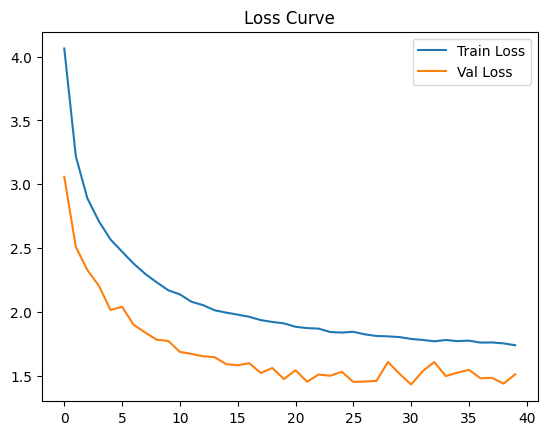

In [31]:
yPred_proba.max(axis=1).mean()

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# Visualization

Great! So we've got our combined model working that incorporates both the raw binary images of the leaves and the pre-extracted features. But you might ask now, what is the neural network actually learning? One easy way to tell what the convolutional portion of the neural net is learning is through visualization of the hidden layers. First, we'll pick a few random leaves from our validation set and we'll pass each one through the neural network. As the leaf goes through, the convolutional neural net will apply many filters each looking for something in the image. Once the filter is applied we'll grab the new image of the leaf and the white portions of the image will tell us where the filter activated and the black will tell us where it didn't. If you take a look at our architecture for the neural net, you'll notice we created 8 filters for the first convolutional layer and 32 for the second one. Thus, for each leaf image we should get a set of 8 and another set of 32 new images.

To do this in Keras we'll build a Keras function as outlined in the [Keras FAQ](https://keras.io/getting-started/faq/#how-can-i-visualize-the-output-of-an-intermediate-layer).

Top 3 Predicitons:
	Quercus_Cerris: 1.0
	Rhododendron_x_Russellianum: 1.80616e-07
	Quercus_Pontica: 9.49196e-09

Actual: Quercus_Cerris


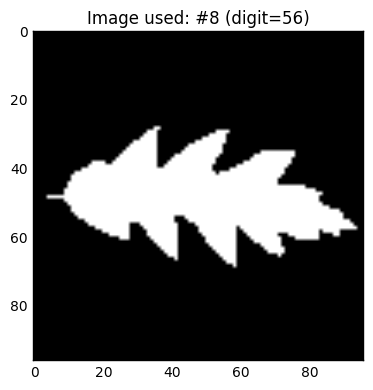

Visualizing Convolutions Layer 0


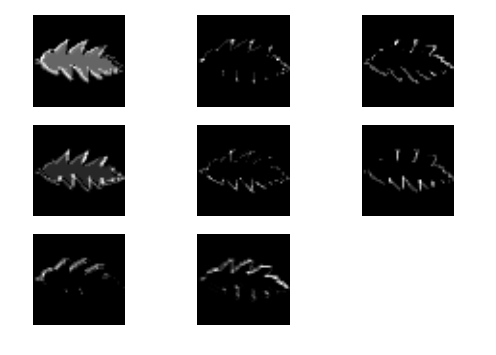

Visualizing Convolutions Layer 1


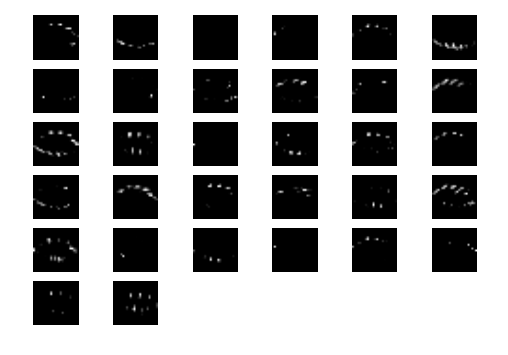

Top 3 Predicitons:
	Acer_Pictum: 1.0
	Quercus_Palustris: 9.10837e-09
	Liquidambar_Styraciflua: 7.37048e-09

Actual: Acer_Pictum


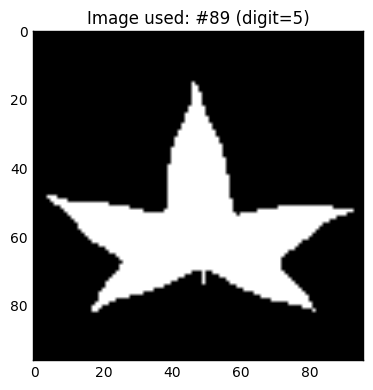

Visualizing Convolutions Layer 0


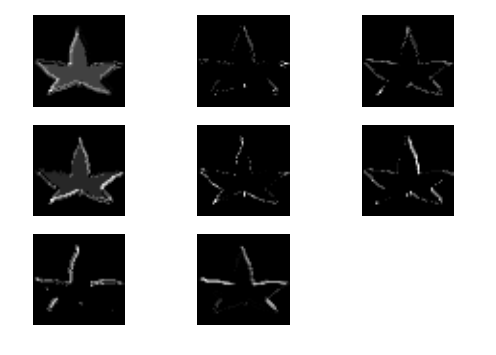

Visualizing Convolutions Layer 1


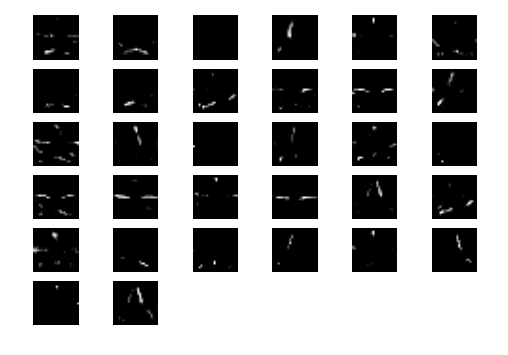

Top 3 Predicitons:
	Acer_Pictum: 1.0
	Quercus_Palustris: 9.10837e-09
	Liquidambar_Styraciflua: 7.37048e-09

Actual: Acer_Pictum


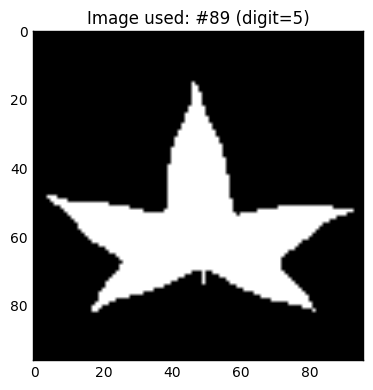

Visualizing Convolutions Layer 0


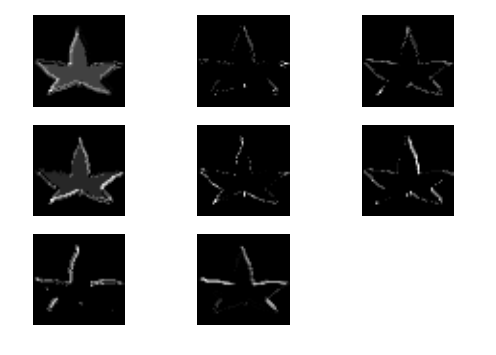

Visualizing Convolutions Layer 1


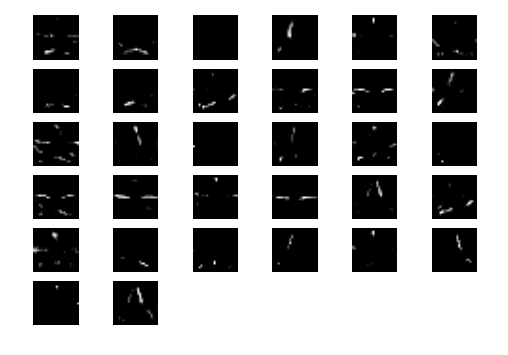

In [ ]:
from math import sqrt

import matplotlib.pyplot as plt
from keras import backend as K

NUM_LEAVES = 3
model_fn = 'leafnet.h5'

# Function by gcalmettes from http://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def plot_figures(figures, nrows = 1, ncols=1, titles=False):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(sorted(figures.keys(), key=lambda s: int(s[3:]))):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        if titles:
            axeslist.ravel()[ind].set_title(title)

    for ind in range(nrows*ncols):
        axeslist.ravel()[ind].set_axis_off()

    if titles:
        plt.tight_layout()
    plt.show()


def get_dim(num):
    """
    Simple function to get the dimensions of a square-ish shape for plotting
    num images
    """

    s = sqrt(num)
    if round(s) < s:
        return (int(s), int(s)+1)
    else:
        return (int(s)+1, int(s)+1)

# Load the best model
model = load_model(model_fn)

# Get the convolutional layers
conv_layers = [layer for layer in model.layers if isinstance(layer, MaxPooling2D)]

# Pick random images to visualize
imgs_to_visualize = np.random.choice(np.arange(0, len(X_img_val)), NUM_LEAVES)

# Use a keras function to extract the conv layer data
convout_func = K.function([model.layers[0].input, K.learning_phase()], [layer.output for layer in conv_layers])
conv_imgs_filts = convout_func([X_img_val[imgs_to_visualize], 0])
# Also get the prediction so we know what we predicted
predictions = model.predict([X_img_val[imgs_to_visualize], X_num_val[imgs_to_visualize]])

imshow = plt.imshow #alias
# Loop through each image disply relevant info
for img_count, img_to_visualize in enumerate(imgs_to_visualize):

    # Get top 3 predictions
    top3_ind = predictions[img_count].argsort()[-3:]
    top3_species = np.array(LABELS)[top3_ind]
    top3_preds = predictions[img_count][top3_ind]

    # Get the actual leaf species
    actual = LABELS[y_val[img_to_visualize]]

    # Display the top 3 predictions and the actual species
    print("Top 3 Predicitons:")
    for i in range(2, -1, -1):
        print("\t%s: %s" % (top3_species[i], top3_preds[i]))
    print("\nActual: %s" % actual)

    # Show the original image
    plt.title("Image used: #%d (digit=%d)" % (img_to_visualize, y_val[img_to_visualize]))
    # For Theano users comment the line below and
    imshow(X_img_val[img_to_visualize][:, :, 0], cmap='gray')
    # imshow(X_img_val[img_to_visualize][0], cmap='gray') # uncomment this
    plt.tight_layout()
    plt.show()

    # Plot the filter images
    for i, conv_imgs_filt in enumerate(conv_imgs_filts):
        conv_img_filt = conv_imgs_filt[img_count]
        print("Visualizing Convolutions Layer %d" % i)
        # Get it ready for the plot_figures function
        # For Theano users comment the line below and
        fig_dict = {'flt{0}'.format(i): conv_img_filt[:, :, i] for i in range(conv_img_filt.shape[-1])}
        # fig_dict = {'flt{0}'.format(i): conv_img_filt[i] for i in range(conv_img_filt.shape[-1])} # uncomment this
        plot_figures(fig_dict, *get_dim(len(fig_dict)))

# Conclusion

For the first convolutional layer we can sort of tell that most of the filters are doing edge detection on the leaf. That actually makes a lot of sense since pretty much all of the species specific information of a leaf is stored in the shape of its edge. The second convolutional layer is also mainly edge detection along with some point and edge shape detection I noticed with some leaves that have particularly special shapes. This is actually pretty common with convnets. The first few layers will do really simple stuff like edge and shape detection, but the deeper you go the more abstract it gets. Since we don't really have enough data to go that deep most of our filters look pretty tame. Judging by our LB score though, I think we can assume what it's doing is fairly constructive.

Well, that's all! If you've made it this far that means you've read my first kernel, and I hope it helps if you're stuck and don't know how to improve your score. In addition to questions, I'm very open to any feedback both in general about kernel writing and specifically about this kernel.

## Thank you for reading!